In [10]:
#Initial commands

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Users\Will\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Before next step, make sure lines in CSV file are randomly shuffled.  Use code from http://stackoverflow.com/questions/4618298/randomly-mix-lines-of-3-million-line-file.  But make sure to keep the first line intact so you don't forget the column names!

Code needs to modified in the following way: <br>
data = lines[1:] <br>
newlines = [lines[0]] + data <br>
write(newlines)

In [11]:
#Import data in batches instead of all at once

OnTimeDataFrames = []
for n in range(15):
    #100,001 rows total: 100,000 of data, plus first row for column names!  Easy to mess up...
    #Note we aren't using lat/long data in the model at the present time, but can change this later
    OnTimeDataFrames.append(pd.read_csv('Sample_2011_2016_carr_mark.csv', nrows=100001,
                                        skiprows=range(1, 1 + 100000*n) if n > 0 else None))

In [12]:
#Check shapes of all data frames - all except the last should have 100,000 rows, all should have same no. of columns
for X in OnTimeDataFrames: print X.shape

(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(100001, 68)
(90434, 68)


In [13]:
#Check column names of second data frame
OnTimeDataFrames[1].columns

Index([u'Unnamed: 0', u'Year', u'Quarter', u'Month', u'DayofMonth',
       u'DayOfWeek', u'FlightDate', u'UniqueCarrier', u'AirlineID', u'Carrier',
       u'TailNum', u'FlightNum', u'OriginAirportID', u'OriginAirportSeqID',
       u'OriginCityMarketID', u'Origin', u'OriginCityName', u'OriginState',
       u'OriginStateFips', u'OriginStateName', u'OriginWac', u'DestAirportID',
       u'DestAirportSeqID', u'DestCityMarketID', u'Dest', u'DestCityName',
       u'DestState', u'DestStateFips', u'DestStateName', u'DestWac',
       u'CRSDepTime', u'DepTime', u'DepDelay', u'DepDelayMinutes', u'DepDel15',
       u'DepartureDelayGroups', u'DepTimeBlk', u'TaxiOut', u'WheelsOff',
       u'WheelsOn', u'TaxiIn', u'CRSArrTime', u'ArrTime', u'ArrDelay',
       u'ArrDelayMinutes', u'ArrDel15', u'ArrivalDelayGroups', u'ArrTimeBlk',
       u'Cancelled', u'CancellationCode', u'CRSElapsedTime',
       u'ActualElapsedTime', u'AirTime', u'Flights', u'Distance',
       u'DistanceGroup', u'CarrierDelay', u'Weat

In [14]:
#Check that all data frames have same column names
assert np.all(X.columns == OnTimeDataFrames[0].columns for X in OnTimeDataFrames)

In [15]:
#Correct ExpressJet Airways issue
for X in OnTimeDataFrames:
    X["Carrier Name"] = X["Carrier Name"].replace("ExpressJet Airlines Inc. (1)",
                                                               "ExpressJet Airlines Inc.")

In [16]:
#Get rid of rows with null values for ArrDelay
OnTimeDataNoNull = [X[np.isfinite(X.ArrDelay)] for X in OnTimeDataFrames]
for X in OnTimeDataNoNull: print X.shape

(98231, 68)
(98163, 68)
(98252, 68)
(98174, 68)
(98197, 68)
(98184, 68)
(98200, 68)
(98205, 68)
(98198, 68)
(98190, 68)
(98234, 68)
(98315, 68)
(98177, 68)
(98145, 68)
(88801, 68)


In [17]:
#Compute interactions for airlines * airports with a certain %
def interactions_aa(X, pct):
    #dictionary of features with percentage "1"s
    PercentageDict = {}
    for feature in X.columns:
        PercentageDict[feature] = X[feature].mean(axis=1)
    #calculate interactions
    X1 = X.copy()
    for feat_A in [name for name in X.columns if name[0] == 'C']:
        for feat_B in [name for name in X.columns if name[0] in list('DO') and PercentageDict[name] > pct]:
            X1[feat_A + "*" + feat_B] = (X1[feat_A].to_dense() * X1[feat_B].to_dense()).to_sparse()
    return X1

In [18]:
#Create dummy variables
def DummyRegressors(data):
    #Create dummies for airline, origin and destination airports, month, and time of day
    #Drop first column in each data frame to avoid singular matrix
    #Also include ArrDelay variable so we don't have to grab this separately from the old data frame
    CarrierDummies = pd.get_dummies(data["Carrier Name"], prefix="C", sparse=True, drop_first=True)
    OriginDummies = pd.get_dummies(data.Origin, prefix="O", sparse=True, drop_first=True)
    DestDummies = pd.get_dummies(data.Dest, prefix="D", sparse=True, drop_first=True)
    MonthDummies = pd.get_dummies(data.Month, prefix="M", sparse=True, drop_first=True)
    TimeDummies = pd.get_dummies(data.DepTimeBlk, prefix="T", sparse=True, drop_first=True)
    ArrDelay = data.ArrDelay
    ArrDel15 = data.ArrDel15
    
    return pd.concat([CarrierDummies, OriginDummies, DestDummies, MonthDummies, TimeDummies,
                      ArrDelay, ArrDel15], axis=1)

In [19]:
DummyTest = DummyRegressors(OnTimeDataNoNull[0])

In [20]:
DummyTest.columns[pd.isnull(DummyTest).any()].tolist()

[]

In [21]:
#Create list of data frames with dummies instead of raw data
OnTimeDummies = [DummyRegressors(X) for X in OnTimeDataNoNull]

In [22]:
for X in OnTimeDummies: print X.shape

(98231, 702)
(98163, 706)
(98252, 703)
(98174, 703)
(98197, 705)
(98184, 705)
(98200, 696)
(98205, 707)
(98198, 707)
(98190, 704)
(98234, 699)
(98315, 698)
(98177, 707)
(98145, 708)
(88801, 701)


Problem: not all airports and airlines are in all the data frames!  This makes sense and is a drawback of reading in the data in separate frames rather than splitting it up afterward.  We need to fix it by making sure if a column name appears in one dummy frame, it appears in all of them.

In [23]:
#create set of dummies that appear in any data frame, so each only appears once
#Try it the less efficient way, but this seems to work
DummyList = []
for X in OnTimeDummies:
    for name in X.columns:
        DummyList.append(name)
DummySet = set(DummyList)
len(DummySet)

718

In [24]:
len(DummySet)

718

In [25]:
#Now add dummies for all variables in set to OnTimeDummies frames
for X in OnTimeDummies:
    SparseZeroes = pd.SparseSeries([0 for n in range(len(X))], index=X.index)
    print len(SparseZeroes), len(X)
    for name in DummySet:
        if name not in X.columns:
            X[name] = SparseZeroes.copy()
            if pd.isnull(X[name]).any(): print name

98231 98231
98163 98163
98252 98252
98174 98174
98197 98197
98184 98184
98200 98200
98205 98205
98198 98198
98190 98190
98234 98234
98315 98315
98177 98177
98145 98145
88801 88801


In [26]:
#Now check shapes of dummy frames again
for X in OnTimeDummies: print X.shape

(98231, 718)
(98163, 718)
(98252, 718)
(98174, 718)
(98197, 718)
(98184, 718)
(98200, 718)
(98205, 718)
(98198, 718)
(98190, 718)
(98234, 718)
(98315, 718)
(98177, 718)
(98145, 718)
(88801, 718)


In [27]:
#create list of data frames with interactions included
#airport threshold: 1.5% of flights
OnTimeDummies_Inter = [interactions_aa(X, .015) for X in OnTimeDummies]

In [28]:
for X in OnTimeDummies_Inter: print X.shape

(98231, 1398)
(98163, 1398)
(98252, 1398)
(98174, 1398)
(98197, 1398)
(98184, 1415)
(98200, 1415)
(98205, 1398)
(98198, 1398)
(98190, 1415)
(98234, 1398)
(98315, 1398)
(98177, 1398)
(98145, 1398)
(88801, 1415)


In [29]:
#Once again the number of dummies is not precisely the same between batches.  We need to do the DummySet procedure again.
InterList = []
for X in OnTimeDummies_Inter:
    for name in X.columns:
        InterList.append(name)
InterSet = set(InterList)
len(InterSet)

1432

In [30]:
#Add interactions to all frames
for X in OnTimeDummies_Inter:
    SparseZeroes = pd.SparseSeries([0 for n in range(len(X))], index=X.index)
    for name in InterSet:
        if name not in X.columns:
            X[name] = SparseZeroes.copy()

In [31]:
#Now check shapes again
for X in OnTimeDummies_Inter: print X.shape

(98231, 1432)
(98163, 1432)
(98252, 1432)
(98174, 1432)
(98197, 1432)
(98184, 1432)
(98200, 1432)
(98205, 1432)
(98198, 1432)
(98190, 1432)
(98234, 1432)
(98315, 1432)
(98177, 1432)
(98145, 1432)
(88801, 1432)


In [32]:
#Divide each interaction data set into training and test data sets
from sklearn.model_selection import train_test_split

In [33]:
OnTime_XTrainFrames, OnTime_XTestFrames, OnTime_YTrainFrames, OnTime_YTestFrames = [], [], [], []
for D in OnTimeDummies_Inter:
    X_train, X_test, Y_train, Y_test = train_test_split(D.drop(["ArrDelay", "ArrDel15"], axis=1), D.ArrDelay)
    OnTime_XTrainFrames.append(X_train)
    OnTime_XTestFrames.append(X_test)
    OnTime_YTrainFrames.append(Y_train)
    OnTime_YTestFrames.append(Y_test)

In [34]:
#import modeling formulas
from sklearn.linear_model import SGDRegressor, SGDClassifier

In [35]:
"""1. linear regression model using SGDRegressor, penalty = L1"""
linear = SGDRegressor(penalty='l1')

In [36]:
#Use SGDRegressor partial_fit function to train model on training data
for n in range(len(OnTime_XTrainFrames)):
    print n
    linear.partial_fit(OnTime_XTrainFrames[n], OnTime_YTrainFrames[n])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [37]:
#Aggregate test data into one frame
# OnTime_XTest = pd.concat(OnTime_XTestFrames, axis=1)

In [38]:
for n in range(len(OnTime_XTestFrames)):
    print n, linear.score(OnTime_XTestFrames[n], OnTime_YTestFrames[n])

0 0.0173533826785
1 0.0145501650826
2 0.0162519987916
3 0.0145889920052
4 0.0144677253264
5 0.0094413997919
6 0.00292301015743
7 0.0174479090113
8 0.0164113958237
9 0.0109301080865
10 0.0156791256877
11 0.01125074783
12 0.0157822455306
13 0.0124434661253
14 0.0256869339656


In [39]:
linear.coef_

array([-4.74342204,  0.70887702,  0.68215968, ...,  0.        ,
        0.        ,  0.        ])

In [40]:
linear.coef_.shape

(1430L,)

In [41]:
linear.intercept_

array([ 1.66835961])

In [42]:
OnTime_XTrainFrames[0].shape

(73673, 1430)

In [43]:
#Assuming coefficients are returned in same order as columns...
LinearCoefDict = {OnTime_XTrainFrames[0].columns[n]: linear.coef_[n] for n in range(1430)}

In [44]:
#Find largest 10 positive coefficients
sorted(LinearCoefDict.items(), key=lambda x:x[1], reverse=True)[:10]

[('O_AZA', 10.550971638263549),
 ('T_2300-2359', 10.5399039196757),
 ('D_DLG', 10.435385739845476),
 ('O_RFD', 10.135992017095649),
 ('C_SkyWest Airlines Inc.*D_SFO', 8.8443834470344473),
 ('C_Spirit Air Lines', 8.7320006403883585),
 ('T_1900-1959', 7.340729768682472),
 ('O_SHD', 7.2736079840995282),
 ('T_2200-2259', 7.1230964783926316),
 ('T_2100-2159', 6.5533369897754605)]

In [45]:
#Find 10 largest negative coefficients
sorted(LinearCoefDict.items(), key=lambda x:x[1])[:10]

[('C_Alaska Airlines Inc.', -4.7434220356156596),
 ('C_SkyWest Airlines Inc.*D_SLC', -4.2936157073568513),
 ('M_10', -3.856472795553485),
 ('C_Hawaiian Airlines Inc.', -3.6967818985592071),
 ('M_12', -3.4511231358271846),
 ('D_PIA', -3.1608316897493931),
 ('M_9', -3.1527925796645917),
 ('M_8', -3.0619844382036807),
 ('T_0600-0659', -2.870705283183197),
 ('C_SkyWest Airlines Inc.*O_SLC', -2.8655559396976051)]

In [46]:
#Calculate predicted values so they can be used in future analysis
LinearPredList = []
for i in range(15):
    LinearPredList.append(np.array(linear.predict(OnTime_XTestFrames[i])))

In [47]:
#Concatenate arrays of predicted values and actual values
LinearPredicted = np.concatenate(LinearPredList)
LinearActual = np.array(np.concatenate(list(OnTime_YTestFrames[i] for i in range(15))))

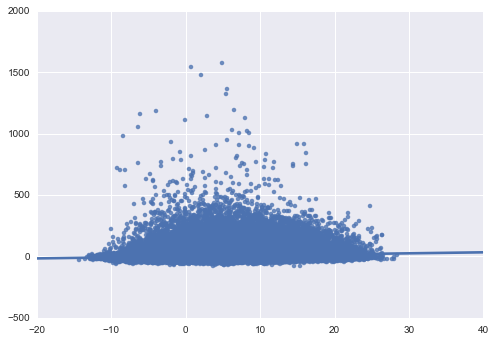

In [48]:
#Regression plot
sns.regplot(x=LinearPredicted, y=LinearActual)

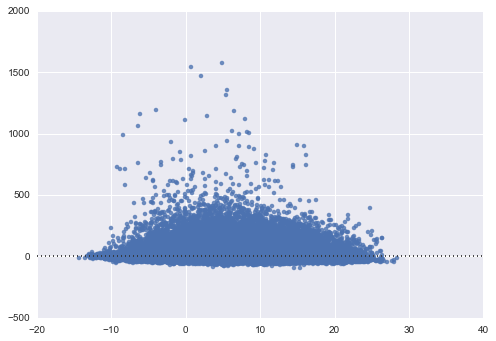

In [49]:
#Residuals vs fitted plot
sns.residplot(x=LinearPredicted, y=LinearActual)

As we see above, a few flights with extreme delays have very large residuals.  There are no corresponding outliers on the negative side - it's hard to have a residual of -1500 minutes as no flights are predicted to be delayed that much.  This could make it appear as if the average residual is not zero, but hopefully the subsequent analysis will show otherwise...

In [50]:
#Generate Residuals
LinearTestResiduals = np.array(LinearActual - LinearPredicted)
LinearTestResiduals.shape

(365923L,)

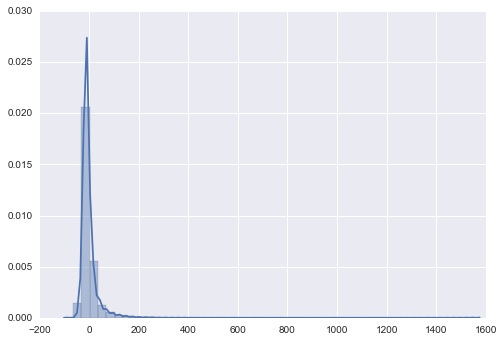

In [51]:
#Histogram of residuals
sns.distplot(LinearTestResiduals)

The peak is a bit below zero, which is good since there is a long tail above zero.  But just to be sure:

In [53]:
np.mean(LinearTestResiduals)

-0.53066107524321815

The average residual is actually slightly negative.  Since we are looking at the test data, which is not the data used to fit the model, the value may not be exactly zero.  But the negative value reinforces the fact that the high outliers are not pulling up the average.

C:\Users\Will\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


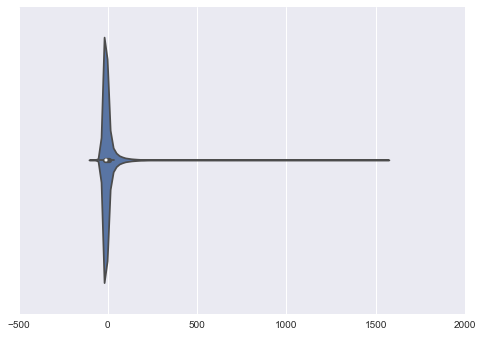

In [54]:
sns.violinplot(LinearTestResiduals)

In [55]:
"""2. Logistic regression using SGDClassifier"""
#Training and testing sets for logistic regression
OnTime_X2TrainFrames, OnTime_X2TestFrames, OnTime_Y2TrainFrames, OnTime_Y2TestFrames = [], [], [], []
for D in OnTimeDummies_Inter:
    X2_train, X2_test, Y2_train, Y2_test = train_test_split(D.drop(["ArrDelay", "ArrDel15"], axis=1), D.ArrDel15)
    OnTime_X2TrainFrames.append(X2_train)
    OnTime_X2TestFrames.append(X2_test)
    OnTime_Y2TrainFrames.append(Y2_train)
    OnTime_Y2TestFrames.append(Y2_test)

In [56]:
logistic = SGDClassifier(penalty='l1', loss='log')

In [57]:
logistic

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [58]:
for n in range(len(OnTime_X2TrainFrames)):
    print n
    logistic.partial_fit(OnTime_X2TrainFrames[n], OnTime_Y2TrainFrames[n],
                        classes=np.array([0, 1]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [59]:
for n in range(len(OnTime_X2TestFrames)):
    print n, logistic.score(OnTime_X2TestFrames[n], OnTime_Y2TestFrames[n])

0 0.81533512501
1 0.812151094087
2 0.812075072263
3 0.812255541069
4 0.817881873727
5 0.812759716451
6 0.809775967413
7 0.812805474096
8 0.814215885947
9 0.811226983868
10 0.810171423918
11 0.814068920623
12 0.812385414545
13 0.813017076252
14 0.812080536913


In [60]:
for n in range(15):
    print OnTime_Y2TrainFrames[n].mean()

0.185739687538
0.189413490533
0.188644166701
0.18743718593
0.188276508208
0.190350090986
0.191581805838
0.189523848316
0.190269932653
0.18865593004
0.18690193417
0.187411847673
0.190080399826
0.188688729486
0.187402402402


In [61]:
#So this model looks good, but it isn't really any better than just predicting "0" for every observation

In [62]:
logistic.coef_

array([[-0.32106618,  0.07347354,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [63]:
logistic.coef_.shape

(1L, 1430L)

In [64]:
logistic.intercept_

array([-1.75569319])

In [65]:
#Assuming coefficients are returned in same order as columns...
LogisticCoefDict = {OnTime_X2TrainFrames[0].columns[n]: logistic.coef_[0][n] for n in range(1430)}

In [66]:
#Find largest 10 positive coefficients
sorted(LogisticCoefDict.items(), key=lambda x:x[1], reverse=True)[:10]

[('O_SHD', 0.81329387529857133),
 ('T_2300-2359', 0.8052687456024864),
 ('O_AZA', 0.73518923975802297),
 ('O_RFD', 0.67419782767666547),
 ('D_DLG', 0.62069568903923589),
 ('T_1600-1659', 0.61951811913380606),
 ('T_1800-1859', 0.60481877914597348),
 ('C_Spirit Air Lines', 0.58809694977285187),
 ('T_1900-1959', 0.57829215676634271),
 ('T_1700-1759', 0.54412943548026738)]

In [67]:
#Find 10 largest negative coefficients
sorted(LogisticCoefDict.items(), key=lambda x:x[1])[:10]

[('C_Hawaiian Airlines Inc.', -0.81626094205906263),
 ('M_12', -0.7288034506261678),
 ('T_0600-0659', -0.40877782487346592),
 ('T_0700-0759', -0.36460966232894376),
 ('D_SJT', -0.32882914446592043),
 ('C_Alaska Airlines Inc.', -0.32106618489964822),
 ('D_PHF', -0.31716655940182675),
 ('M_8', -0.27559304260182654),
 ('C_Delta Air Lines Inc.', -0.23966268012992942),
 ('M_10', -0.21223600816165056)]

In [68]:
#Calculate predicted values so they can be used in future analysis
LogisticPredList = []
for i in range(15):
    LogisticPredList.append(np.array(logistic.predict(OnTime_X2TestFrames[i])))

In [69]:
#Concatenate arrays of predicted values and actual values
LogisticPredicted = np.concatenate(LogisticPredList)
LogisticActual = np.array(np.concatenate(list(OnTime_Y2TestFrames[i] for i in range(15))))

In [71]:
#Create ROC curves for each batch
from sklearn.metrics import roc_curve
ROC = roc_curve(y_true=LogisticActual, y_score=LogisticPredicted)

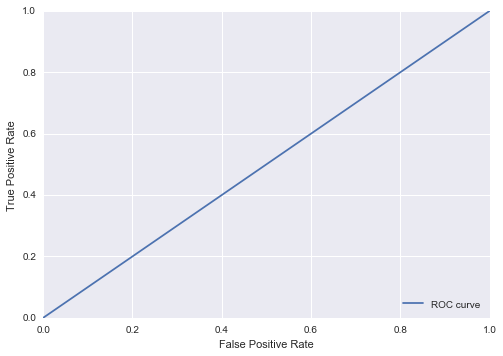

In [72]:
#Plot ROC curve
plt.figure()
plt.plot(ROC[0], ROC[1], label='ROC curve')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [73]:
#Print F1 score
# F1 = 2 * (precision * recall) / (precision + recall)
from sklearn.metrics import f1_score
print "The F1 score is %0.4f" %(f1_score(y_true=LogisticActual, y_pred=LogisticPredicted))

The F1 score is 0.0002


In [74]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_true=LogisticActual, y_pred=LogisticPredicted)

[[297422     19]
 [ 68475      7]]


In [75]:
#Do probabilistic predictions and rerun ROC curves, confusion matrices based on different probabilities
LogisticProbList = []
for i in range(15):
    LogisticProbList.append(np.array(logistic.predict_proba(OnTime_X2TestFrames[i])))
LogisticProbabilities = np.concatenate(LogisticProbList)

In [89]:
#Create dictionary of arrays of "predicted" values where the value is 1 if probability > p
LogisticProbGreater = {}

#Test
p = .5
LogisticProbGreater[p] = map(lambda x: 1 if x[1] > p else 0, LogisticProbabilities)
assert all(LogisticProbGreater[.5] == LogisticPredicted)

#Actual
prob_tests = [.01, .05, .1, .15, .2, .25, .3]
prob_tests.reverse()
for p in prob_tests:
    LogisticProbGreater[p] = map(lambda x: 1 if x[1] > p else 0, LogisticProbabilities)

In [91]:
#Create confusion matrices for each definition of "positive" by probability
for p in prob_tests:
    print "Confusion matrix: cutoff %0.2f:" %p
    print confusion_matrix(y_true=LogisticActual, y_pred=LogisticProbGreater[p])

Confusion matrix: cutoff 0.30:
[[276348  21093]
 [ 60097   8385]]
Confusion matrix: cutoff 0.25:
[[238926  58515]
 [ 48209  20273]]
Confusion matrix: cutoff 0.20:
[[174377 123064]
 [ 31105  37377]]
Confusion matrix: cutoff 0.15:
[[ 91979 205462]
 [ 13761  54721]]
Confusion matrix: cutoff 0.10:
[[ 22632 274809]
 [  2612  65870]]
Confusion matrix: cutoff 0.05:
[[   584 296857]
 [    57  68425]]
Confusion matrix: cutoff 0.01:
[[     0 297441]
 [     0  68482]]


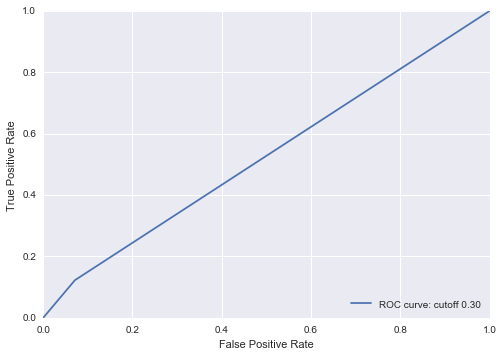

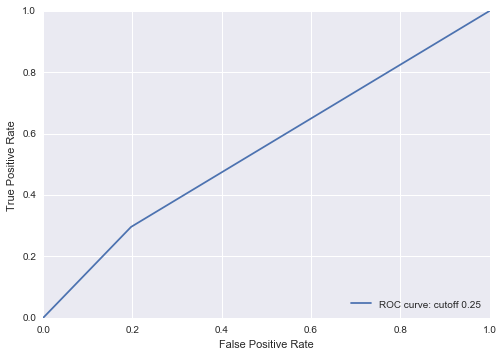

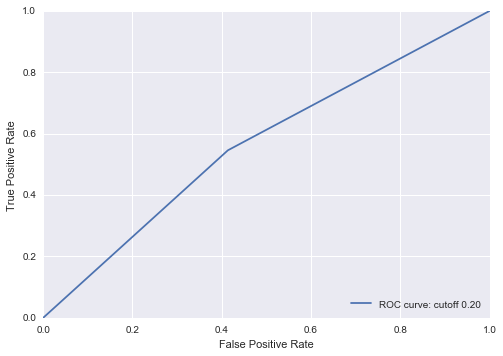

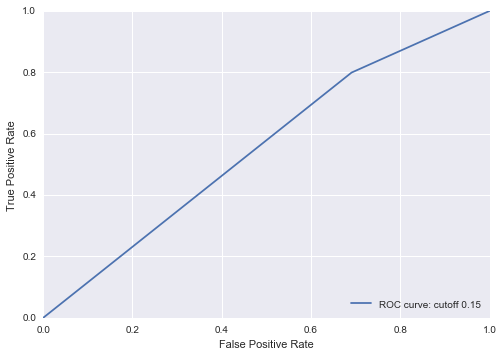

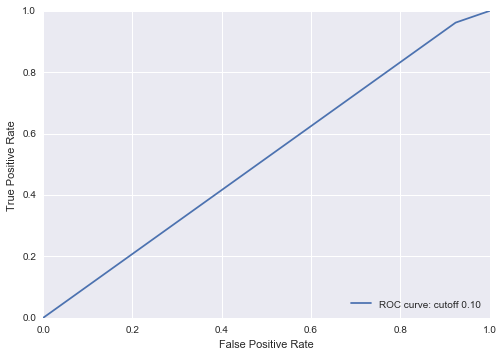

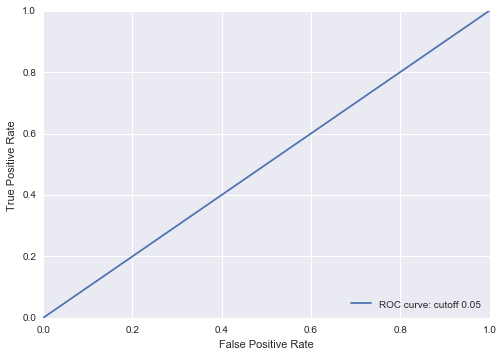

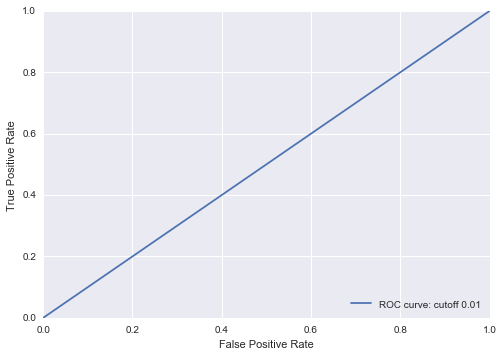

In [92]:
#Create ROC curve for each definition of "positive" by probability
for p in prob_tests:
    ROC_new = roc_curve(y_true=LogisticActual, y_score=LogisticProbGreater[p])
    plt.figure()
    plt.plot(ROC_new[0], ROC_new[1], label='ROC curve: cutoff %0.2f' %p)
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

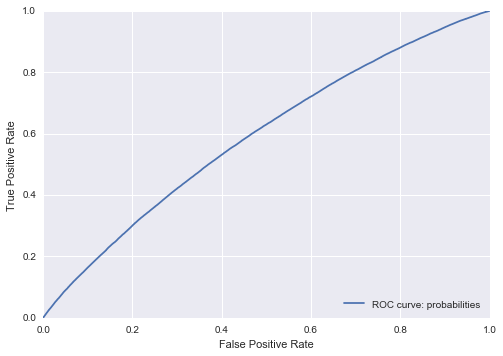

In [100]:
#Create ROC curve using probabilities instead of predicted values
ROC_prob = roc_curve(y_true=LogisticActual, y_score=LogisticProbabilities[:,1])
plt.figure()
plt.plot(ROC_prob[0], ROC_prob[1], label='ROC curve: probabilities')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')